### Work left to do

##### 1(Abdul). Create a script that queries the Google Books API for each book in the books_data.csv dataset and retrieves the pageCount and averageRating fields from the response and adds them as columns to the enhanced_books_data.csv

##### Expected columns: book_title, page_count, average_rating 

##### 2(Joseph). Sentiment analysis of the review/text to produce a column with either a positive(1) or negative(1) sentiment; said column can be used as a feature in a ML model

##### 3. Four models have been built

###### 1. Linear regression - Joseph draft 
###### 2. K-nearest neighbors - Joseph draft 
###### 3. _ model - Brian 
###### 4. _ model - Griffin 

##### 4(everyone). Analysis and Evaluation of model performance/model comparison

##### 5(everyone). Lessons learned/things we would do differently/things we would do if we had more time 

# Everyone should be working in a single notebook. 

# Data pre-processing/filtering/cleaning

In [ ]:
pip install textblob

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from textblob import TextBlob

books_refined_file_path = './data/refined/filtered_books.csv'
book_ratings_file_path = './data/refined/filtered_book_ratings.csv'

In [ ]:
books = pd.read_csv(books_refined_file_path, usecols=["title","ratings_count", "published_date"])

books['published_date'] = books['published_date'].astype(int)
books = books[books["ratings_count"] >= 20]

In [ ]:
book_ratings = pd.read_csv(book_ratings_file_path, usecols=["user_id", "title", "price", "rating", "review_text", "review_summary"])

In [ ]:
book_ratings_sum = book_ratings.groupby('title')['rating'].sum()
book_ratings_sum = book_ratings_sum.to_frame('book_ratings_sum')

In [ ]:
book_ratings_count = book_ratings.groupby('title')['rating'].size()
book_ratings_count = book_ratings_count.to_frame('book_ratings_count')

In [ ]:
merged_book_attributes = books.merge(book_ratings, on='title', how='inner')\
                              .drop_duplicates(subset=['title', 'user_id'], keep=False)

merged_book_attributes = merged_book_attributes.merge(book_ratings_sum, on='title', how='left')
merged_book_attributes = merged_book_attributes.merge(book_ratings_count, on='title', how='left')

merged_book_attributes["books_average_rating"] = (merged_book_attributes['book_ratings_sum'] - merged_book_attributes['rating']) / (merged_book_attributes['book_ratings_count'] - 1)
merged_book_attributes['books_average_rating'] = merged_book_attributes['books_average_rating'].fillna(book_ratings['rating'].mean())
                                
merged_book_attributes = merged_book_attributes[['price', 'review_summary', 'review_text', 'books_average_rating', 'rating']]

merged_book_attributes['full_review_sentiment_score'] = merged_book_attributes['review_text'].apply(lambda review: TextBlob(review).sentiment.polarity)
merged_book_attributes['review_summary_sentiment_score'] = merged_book_attributes['review_summary'].apply(lambda review_summary: TextBlob(review_summary).sentiment.polarity)

merged_book_attributes.drop('review_summary', axis=1, inplace=True)
merged_book_attributes.drop('review_text', axis=1, inplace=True)

columns = ['price', 'full_review_sentiment_score', 'review_summary_sentiment_score', 'books_average_rating', 'rating']
merged_book_attributes = merged_book_attributes.reindex(columns=columns)

merged_book_attributes.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_book_attributes[['price', 'full_review_sentiment_score', 'review_summary_sentiment_score', 'books_average_rating']], merged_book_attributes[['rating']], test_size=0.2, random_state=42)

# Linear regression

In [ ]:
lnr_regressor = LinearRegression()

In [ ]:
lnr_regressor.fit(X_train, y_train)

In [ ]:
ratings_y_pred = lnr_regressor.predict(X_test)

In [ ]:
print(f"Coefficients: {lnr_regressor.coef_}")
print(f"r2 score on test data: {r2_score(y_test, ratings_y_pred)}")

# K-nearest neighbors 

In [ ]:
knn_regressor = KNeighborsRegressor()
param_grid = {'n_neighbors': range(1, 17), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best r2 score:", grid_search.best_score_)

In [ ]:
best_params = grid_search.best_params_
knn_regressor = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

In [ ]:
knn_regressor.fit(X_train, y_train)

In [ ]:
print(f"r2 score on test data: {knn_regressor.score(X_test, y_test)}")

In [ ]:
print(f"r2 score on test data: {rf_regressor.score(X_test, y_test)}")

In [ ]:
knn_models = []
for k in range(1, 17):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_models.append(knn_regressor)

In [ ]:
mse_values = []
for index, knn_regressor in enumerate(knn_models):
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

In [ ]:
plt.plot([i for i in range(1, len(knn_models) + 1)], mse_values)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow plot for k-nearest neighbors regression model')
plt.show()

# Random Forests

In [ ]:
param_grid = {
    "n_estimators": [x for x in range(200, 2001, 200)],
    "max_features": ["log2", "sqrt"],
    "max_depth": [x for x in range(10, 110, 10)],
    "min_samples_split": [2, 4, 8],
    "bootstrap": [True, False]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, n_jobs=-1, cv=5, scoring='r2')

random_search.fit(X_train, y_train.values.ravel())

print("Best parameters:", random_search.best_params_)
print("Best r2 score:", random_search.best_score_)

In [ ]:
best_params = random_search.best_params_
rf_regressor = RandomForestRegressor(n_estimators=best_params['n_estimators'], min_samples_split=best_params['min_samples_split'], max_features=best_params['max_features'], max_depth=best_params['max_depth'], bootstrap=best_params['bootstrap'])

In [ ]:
rf_regressor.fit(X_train, y_train.values.ravel())

In [ ]:
print(f"r2 score on test data: {rf_regressor.score(X_test, y_test)}")

# Neural Network

In [1]:
!pip install boto3==1.28.3
!pip install pandas==1.5.3
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 47.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 874.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.142
    Uninstalling botocore-1.34.142:
      Successfully uninstalled botocore-1.34.142
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.10.1
    Uninstalling s3transfer-0.10.1:
      Successfully uninstalled s3transfer-0.10.1
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.142
    Uninstalling boto3-1.34.142:
      Successfully uninstalled boto3-1.34.142
ERROR: 

In [1]:
import boto3 as b3
import pandas as pds
import tensorflow as tf
import numpy as np
from io import BytesIO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

2024-08-02 09:18:57.593165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 09:18:59.412057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Initial set-up: --------------------------------------------------------------------------------

# Grab s3
s3 = b3.client('s3')

# Bucket set-up
the_bucket = 'groupproject-balducci'
books_key = 'books_data.csv'
ratings_key = 'Books_rating.csv'

In [3]:
# Fetch books data and store
books_data_object = s3.get_object(Bucket = the_bucket, Key = books_key)
books_data = pds.read_csv(BytesIO(books_data_object['Body'].read()))

# Fetch user ratings data and store
books_rating_object = s3.get_object(Bucket = the_bucket, Key = ratings_key)
books_rating = pds.read_csv(BytesIO(books_rating_object['Body'].read()))

# Sample a fraction of the data
fraction_to_sample = 0.12
books_data_sample = books_data.sample(frac=fraction_to_sample, random_state=1)
books_rating_sample = books_rating.sample(frac=fraction_to_sample, random_state=1)

# Merge data together (Merge with 'Title' as the key and only merge rows that occur in both files)
all_data = pds.merge(books_data_sample, books_rating_sample, on='Title', how='inner')

In [4]:
# Data Preprocessing: ----------------------------------------------------------------------------

# Replace missing values in DataFrame with 0
all_data = all_data.fillna(0)

# Create a matrix of users (rows) to books (columns) based on user ratings
rating_matrix = all_data.pivot_table(index = 'User_id', columns = 'Title', values = 'review/score')

# If user hasn't rated a book add a zero
rating_matrix = rating_matrix.fillna(0)

from sklearn.preprocessing import LabelEncoder

# Convert User_id and Title to strings to allow encoding
all_data['User_id'] = all_data['User_id'].astype(str)
all_data['Title'] = all_data['Title'].astype(str)

# Create encoders for users and books
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

# Encode them
all_data['User_id_encoded'] = user_encoder.fit_transform(all_data['User_id'])
all_data['Title_encoded'] = book_encoder.fit_transform(all_data['Title'])

# Create X as an array of [User_id_encoded, Title_encoded] objects
X = all_data[['User_id_encoded', 'Title_encoded']].values

# Create y as an array of review/scores
y = all_data['review/score'].values

# TT set splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [5]:
# Neural Network Model: --------------------------------------------------------------------------

# Tell TF to not look for GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Grab counts:
user_count = len(rating_matrix.index)
item_count = len(rating_matrix.columns)

# Feature count per user (Smaller is less costly but less accurate)
embedding_size = 50

# Model start
model = Sequential()

# Using User_id as the input (1)
model.add(Input(shape = [2]))

# Convert each user to into a profile of embedding_size
model.add(Embedding(input_dim = user_count + item_count, output_dim = embedding_size, input_length=2))

# Flatten profiles into single lines
model.add(Flatten())

# Create the hidden layer (64 neurons)
model.add(Dense(64, activation = 'relu'))

# Create the output layer
model.add(Dense(1, activation='linear'))

# Compile time! (Using Regression)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, validation_split=0.1)

# Prediction
y_pred = model.predict(X_test).flatten()

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 score on test data: {r2}")

2024-08-02 09:21:31.836698: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/25
989/989 [==============================] - 13s 12ms/step - loss: 3.0123 - mae: 1.2929 - val_loss: 1.3517 - val_mae: 0.9105
Epoch 2/25
989/989 [==============================] - 12s 12ms/step - loss: 0.8245 - mae: 0.6597 - val_loss: 1.4284 - val_mae: 0.9537
Epoch 3/25
989/989 [==============================] - 12s 12ms/step - loss: 0.4432 - mae: 0.4417 - val_loss: 1.3763 - val_mae: 0.8994
Epoch 4/25
989/989 [==============================] - 12s 12ms/step - loss: 0.3397 - mae: 0.3492 - val_loss: 1.4214 - val_mae: 0.9331
Epoch 5/25
989/989 [==============================] - 12s 12ms/step - loss: 0.2979 - mae: 0.3088 - val_loss: 1.4162 - val_mae: 0.9254
Epoch 6/25
989/989 [==============================] - 12s 12ms/step - loss: 0.2779 - mae: 0.2914 - val_loss: 1.4341 - val_mae: 0.9432
Epoch 7/25
989/989 [==============================] - 12s 12ms/step - loss: 0.2640 - mae: 0.2767 - val_loss: 1.4728 - val_mae: 0.9492
Epoch 8/25
989/989 [==============================] - 12s 12ms

275/275 [==============================] - 0s 756us/step


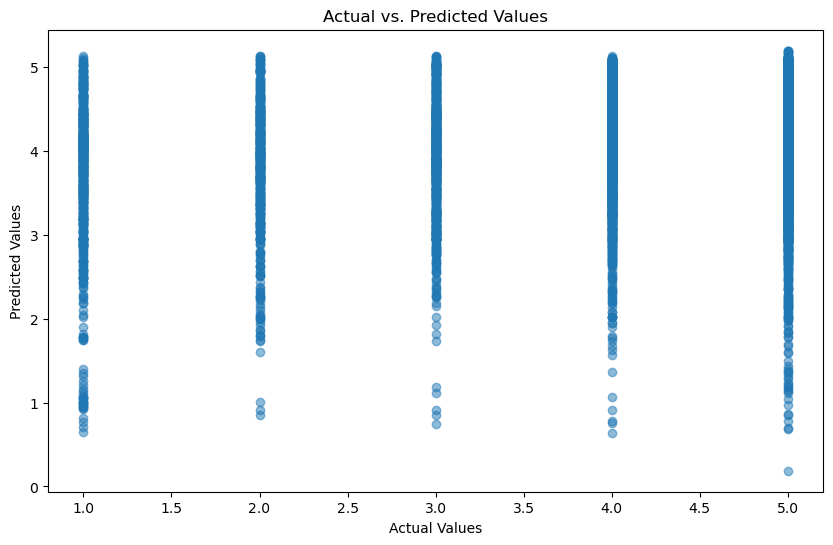

In [8]:
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test).flatten()

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()